In [1]:
import tensorflow as tf
from tensorflow import keras
from skimage import io
from skimage.io import imread_collection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
import PIL
import os

2023-03-01 10:54:06.429644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch Data (Images)
We begin by fetching a dataset of 10,000 images from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com). We do so by requesting from the endpoint `thispersondoesnotexist.com/images` 10,000 (k) times.

#### Declare Paths & File Types

In [2]:
image_path = "./data/training"

In [3]:
current_img_type = "png"

#### Saving an image

In [4]:
def save_image(image, count):
        with open(f'{image_path}/img_{count}.{current_img_type}', 'wb') as f:
            f.write(image)

#### Scraping images from `thispersondoesnotexists.com`

In [5]:
def fetch_images(k: int, folder_name: str):
    """ 
    Fetch images from thispersondoesnotexist.com
    
    :param k: number of images to fetch
    :param folder_name: name of folder to save images to
    """
    if k < 1:
        return 0
    
    # Locals
    count = 0
    endpoint = 'image'
    url = f'https://thispersondoesnotexist.com/{endpoint}'
    while count < k:
        image = requests.get(url).content
        save_image(image)
        count += 1
        
        # A time.sleep(x) is recommended to avoid latency errors

If we'd like to scrape the images, simply call
```python
fetch_images(k=10_000, folder_name='training')
```

## Validating image
We should validate wether the image exists

#### Reading an Image
Uses `skimage` to read image

In [6]:
def read_image(folder_name:str, image_name:str, img_type:str) -> np.ndarray:
    return io.imread(f'{folder_name}/{image_name}.{img_type}')

The following example reads in an image:

```python
read_image('data/training', 'img_3', 'png')
```

#### Checking whether an images exists

In [7]:
def image_exists(folder_name:str) -> bool:
    """ 
    Check whether an image exists in folder_name
    
    :param folder_name: folder in which dataset images are located
    """
    try:
        # Default image 0
        image = read_image(image_path,'img_0', 0)
        return True
    except:
        print(f'Image "img_0.{current_img_type}" in {folder_name} not found')
        return False

## Showing a batch
We can see a random batch of images from the dataset

In [8]:
def show_batch(batch):
    
    # Default batch_size of 3
    images = np.random.randint(low=0, high=len(batch), size=9) # get random indices
    fig = plt.figure(figsize= (3, 3)) 
    fig, axs = plt.subplots(3,3, sharex=True, sharey=True)
    cnt = 0 
    for i in range(3):
        for j in range(3):
            axs[i, j].imshow(batch[images[cnt]]) # get image from batch at index 'i'
            cnt += 1
    plt.show()

### Image Attributes

#### Reading collection of images from folder

In [9]:
def read_collection(folder_name:str) -> io.collection.ImageCollection:
    return imread_collection(f'./{folder_name}/*.{current_img_type}')

We read and store the collection

In [10]:
collection = read_collection(image_path)

In [11]:
len(collection)

8892

<Figure size 216x216 with 0 Axes>

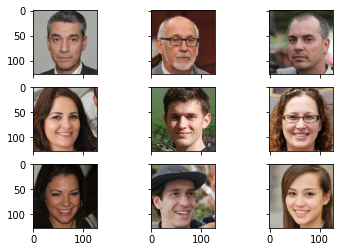

In [12]:
show_batch(collection)

In [13]:
collection[0].shape

(128, 128, 3)

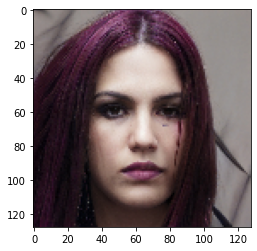

In [14]:
plt.imshow(collection[0])

### Resizing Images
As we can see, all images fetched are $w \times h \times c$, it is necessary we resize these into smaller dimensions to efficiently approach this DCGAN.

We import `CV2` to resize the images in `./images`

In [15]:
import cv2

We now resize every image in the `collection` and update them with given the new dimensions. All images in `collection` are named as their appropriate index in this list

In [16]:
def make_directory(folder_name: str):
    if not os.path.exists(f'./{folder_name}'):
        os.makedirs(folder_name)

In [17]:
def resize_image(image, size) -> PIL.Image.Image:
    resized_image = cv2.resize(image, dsize=size, interpolation=cv2.INTER_CUBIC)
    return Image.fromarray(resized_image)

In [18]:
def resize_collection(folder_name:str, file_name:str, collection):
    make_dir(folder_name)
        
    for i in range(len(collection)): 
        new_image = resize_image(collection[i], (128, 128)) 
        new_image.save(f'./{file_name}/img_{i}.png')

### Neural Network - 1.0
We begin by definning attributes. All images in the dataset are from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com), therefore all images are $1024 \times 1024$ with $3$ channels. However, our sizing may be $w \times h \times c$ if resized.

In [19]:
rows = collection[0].shape[0]
cols = collection[0].shape[1]
channels = collection[0].shape[2]

In [20]:
image_shape = (rows, cols, channels)

`z_dim` represents the dimenions of the noise vector to be inputed into the generator

In [21]:
image_shape

(128, 128, 3)

We first import libraries to be used

In [22]:
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Activation, Conv2D, BatchNormalization, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

import time

In [23]:
z_dim = 128 

We implement the schematics for $G(z)$ for generating $1024 \times 1024$ images from [Marchesi, Marco. (2017). Megapixel Size Image Creation using Generative Adversarial Networks.](https://www.researchgate.net/publication/317300265_Megapixel_Size_Image_Creation_using_Generative_Adversarial_Networks), [Karras, Aila. (2018). Progressive Growing of GANs for Improved Quality Stability, and Variation.](https://arxiv.org/pdf/1710.10196.pdf). Our approach will be different. Assistance from these papers is taken.

#### Model to Image

In [24]:
def model_to_png(model, file_name:str):
    plot_model(model, to_file=f'{file_name}.png', show_shapes=True)

#### Generator 

In [25]:
def create_generator(z) -> keras.models.Sequential:
    model = Sequential()

    # Input Latent vector
    model.add(Dense(4*4*128, input_dim=z))
    model.add(Reshape((4, 4, 128)))
    
    # Conv
    model.add(Conv2DTranspose(128, kernel_size=4, strides=4, padding='valid'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(32, kernel_size=3, strides=4, padding='same'))   
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(16, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))    
    model.add(Activation('tanh'))
    model.summary()
    
    return model

In [26]:
def test_generator(z_dim:int):
    gen = create_generator(z_dim)
    noise = tf.random.normal([1, z_dim])
    img = gen.predict(noise)
    img = tf.reshape(img, shape=(img.shape[1], img.shape[2], img.shape[3]))
    plt.imshow(img)
    plt.show()

To test it:

2023-03-01 10:54:13.553602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              264192    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


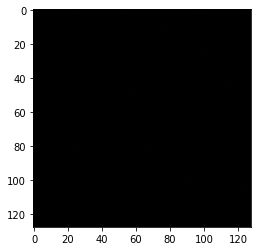

In [27]:
test_generator(z_dim)

#### Discriminator

In [28]:
def create_discriminator(img_shape) -> keras.models.Sequential:
    model = Sequential()
    model.add(Conv2D(3, kernel_size=1, padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 1.0
    model.add(Conv2D(16, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Conv 2.0
    model.add(Conv2D(32, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 3.0
    model.add(Conv2D(64, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 3.0
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 4.0
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))

    # Conv 5.0
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))
              
    # Finalized
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

#### Set up (S) - 1.1 Create
We begin by initializing the discriminator and generator

In [29]:
generator = create_generator(z=z_dim)
discriminator = create_discriminator(img_shape=image_shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              264192    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 64)      

#### S - 1.2 Compile 
We now compile both models.

##### Generator Compile

In [30]:
generator.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0002, beta_1=0.4))

##### Discriminator Compile

In [31]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0002, beta_1=0.4),
                      metrics=['accuracy'])

#### S - 1.3 Disable Discriminator Training

In [32]:
discriminator.trainable = False

Alternatively, if we wanted to get the models as an image, we'd do:
```python
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

plot_model(generator, to_file='generator.png', show_shapes=True, show_dtype=True, show_layer_names=True)
```

In [33]:
def DCGAN(generator, discriminator) -> keras.models.Sequential:
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

In [34]:
gan = DCGAN(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

#### S - 1.4.1 Params

#### Time Stamping

In [35]:
def time_stamp(msg:str, time):
    print(f'{msg} - {time}')

#### Getting current time

In [36]:
def get_time() -> time.ctime:
    return time.ctime(time.time())

#### Training settings

In [37]:
iterations = 2_000
batch_size = 32
sample_interval = 50
folder_name = 'model-02'

In [38]:
discriminator_losses = []
gan_losses = []

In [39]:
def train_gan(iterations:int, batch_size:int, sample_interval:int, folder_name:str):
    data_images = read_collection(image_path)
    image_count = 0
    
    # Labels 
    time_stamp("Generating labels ...", get_time())
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    time_stamp("Finishing ...", get_time())
    
    make_directory(folder_name)
    make_directory(f'{folder_name}/predictions')
    
    # Training
    for iteration in range(iterations):
        # time_stamp(f'Iteration {iteration} of {iterations}', get_time())
        
        # Collect batch
        random_indicies =  np.random.choice(len(data_images), size=batch_size, replace=False)
        real_image_batch = np.array([data_images[i] for i in random_indicies]) / 127.5 - 1.0 # rescale [-1,1]
        
        # Random batch of fake images
        z_fake = tf.random.normal([batch_size, 128])

        generated_images = generator.predict(z_fake)
        
        # Train Discriminator -> [Loss, Accuracy]
        discriminator_real_loss = discriminator.train_on_batch(real_image_batch, real_labels)       
        discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake_labels)
        
        # Get Discriminator loss and accuracy
        discriminator_loss, accuracy = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
        
        # Train Generator
        z_fake = tf.random.normal([batch_size, 128])
        generated_images = generator.predict(z_fake)
        
        
        # Get Generator loss and accuracy
        gan_loss = gan.train_on_batch(z_fake, real_labels)
        
        discriminator_losses.append(discriminator_loss)
        gan_losses.append(gan_loss)
        # Progress output
        if (iteration + 1) % sample_interval == 0:
            print("Iteration %d [D loss: %f, acc.:%.2f%%] [G loss: %f]" % (iteration + 1, discriminator_loss, 100.0* accuracy, gan_loss))
            
            # Generate random images
            z_generated = tf.random.normal([3*3, 128])
            generate_images = generator.predict(z_generated)
            generate_images = 0.5 * generate_images + 0.5
            
            # Plot
            fig = plt.figure(figsize= (3, 3)) 
            fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
            cnt = 0 
            for i in range(3):
                for j in range(3):
                    axs[i, j].imshow(generate_images[cnt]) # get image from batch at index 'i'
                    cnt += 1
            plt.savefig(f'./{folder_name}/predictions/iteration-{image_count}.png')
            image_count += 1
            plt.show()
    generator.save(f'./{folder_name}/generator')
    discriminator.save(f'./{folder_name}/discriminator')
    gan.save(f'./{folder_name}/gan')

#### Training the network
```python
train_gan(iterations, batch_size, sample_interval)
```

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Generating labels ... - Wed Mar  1 10:54:15 2023
Finishing ... - Wed Mar  1 10:54:15 2023
1/1 [==============================] - 0s 99ms/step
Iteration 50 [D loss: 0.561446, acc.:68.75%] [G loss: 0.826749]
1/1 [==============================] - 0s 289ms/step


<Figure size 216x216 with 0 Axes>

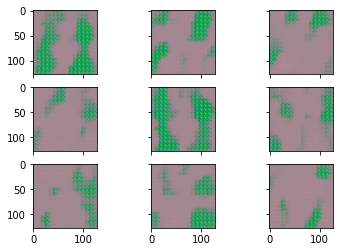

1/1 [==============================] - 0s 97ms/step
Iteration 100 [D loss: 0.532484, acc.:75.00%] [G loss: 1.635162]
1/1 [==============================] - 0s 45ms/step


<Figure size 216x216 with 0 Axes>

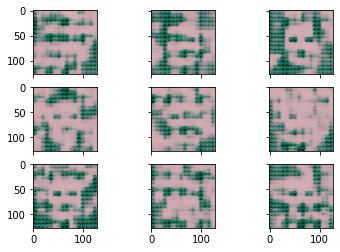

1/1 [==============================] - 0s 88ms/step
Iteration 150 [D loss: 0.228048, acc.:96.88%] [G loss: 2.532997]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

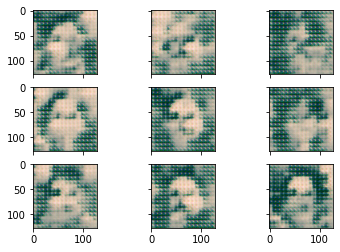

1/1 [==============================] - 0s 92ms/step
Iteration 200 [D loss: 0.199911, acc.:96.88%] [G loss: 2.111626]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

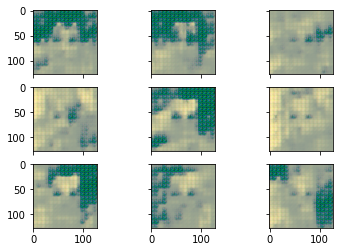

1/1 [==============================] - 0s 90ms/step
Iteration 250 [D loss: 0.310018, acc.:90.62%] [G loss: 2.877208]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

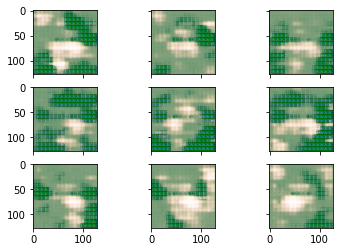

1/1 [==============================] - 0s 87ms/step
Iteration 300 [D loss: 0.578357, acc.:70.31%] [G loss: 2.002419]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

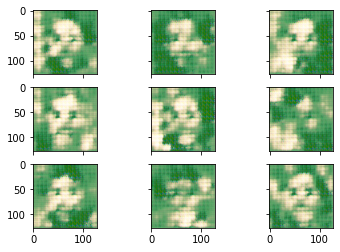

1/1 [==============================] - 0s 99ms/step
Iteration 350 [D loss: 0.542841, acc.:73.44%] [G loss: 2.475372]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

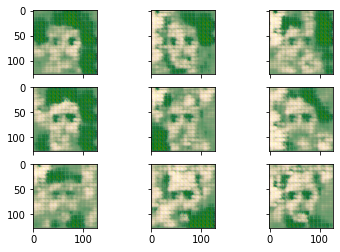

1/1 [==============================] - 0s 96ms/step
Iteration 400 [D loss: 0.509187, acc.:78.12%] [G loss: 1.860046]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

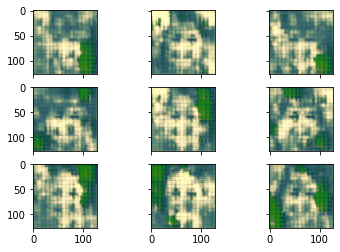

1/1 [==============================] - 0s 95ms/step
Iteration 450 [D loss: 0.233752, acc.:93.75%] [G loss: 2.457839]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

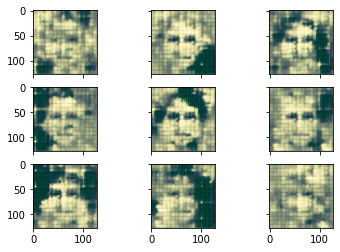

1/1 [==============================] - 0s 92ms/step
Iteration 500 [D loss: 0.273824, acc.:90.62%] [G loss: 2.622202]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

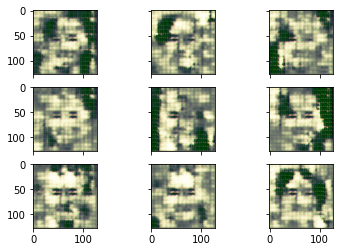

1/1 [==============================] - 0s 89ms/step
Iteration 550 [D loss: 0.372771, acc.:81.25%] [G loss: 2.896060]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

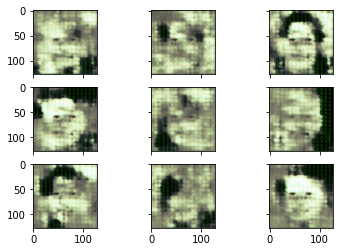

1/1 [==============================] - 0s 98ms/step
Iteration 600 [D loss: 0.449920, acc.:81.25%] [G loss: 1.906859]
1/1 [==============================] - 0s 45ms/step


<Figure size 216x216 with 0 Axes>

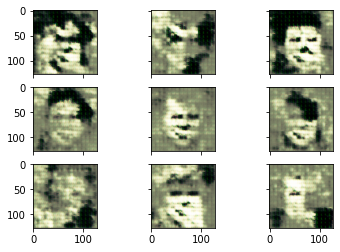

1/1 [==============================] - 0s 128ms/step
Iteration 650 [D loss: 0.545069, acc.:67.19%] [G loss: 1.735010]
1/1 [==============================] - 0s 53ms/step


<Figure size 216x216 with 0 Axes>

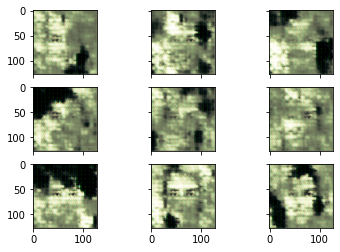

1/1 [==============================] - 0s 89ms/step
Iteration 700 [D loss: 0.428065, acc.:87.50%] [G loss: 1.668840]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

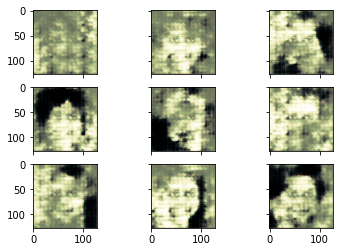

1/1 [==============================] - 0s 90ms/step
Iteration 750 [D loss: 0.393973, acc.:85.94%] [G loss: 2.544498]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

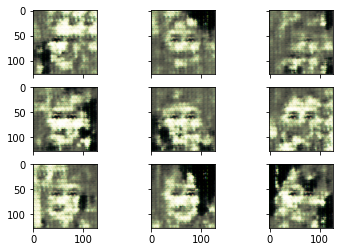

1/1 [==============================] - 0s 95ms/step
Iteration 800 [D loss: 0.653573, acc.:64.06%] [G loss: 1.926844]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

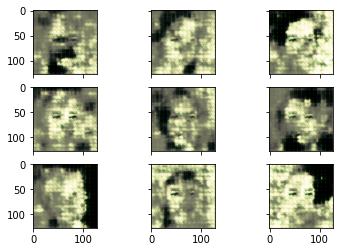

1/1 [==============================] - 0s 89ms/step
Iteration 850 [D loss: 0.248482, acc.:93.75%] [G loss: 2.447365]
1/1 [==============================] - 0s 45ms/step


<Figure size 216x216 with 0 Axes>

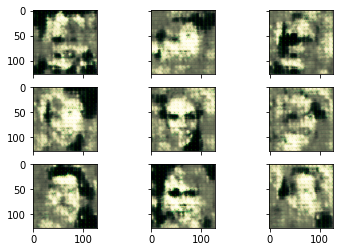

1/1 [==============================] - 0s 95ms/step
Iteration 900 [D loss: 0.368680, acc.:82.81%] [G loss: 2.289771]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

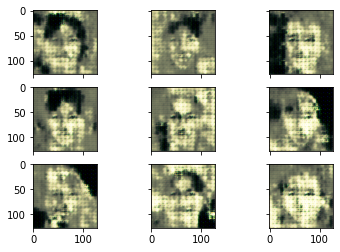

1/1 [==============================] - 0s 96ms/step
Iteration 950 [D loss: 0.425588, acc.:82.81%] [G loss: 1.929208]
1/1 [==============================] - 0s 51ms/step


<Figure size 216x216 with 0 Axes>

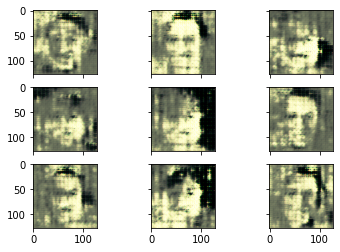

1/1 [==============================] - 0s 100ms/step
Iteration 1000 [D loss: 0.444754, acc.:81.25%] [G loss: 1.759153]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

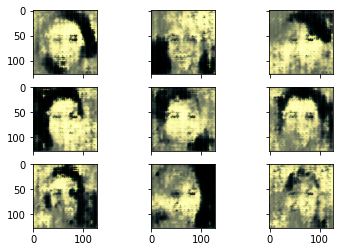

1/1 [==============================] - 0s 94ms/step
Iteration 1050 [D loss: 0.497454, acc.:79.69%] [G loss: 2.167618]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

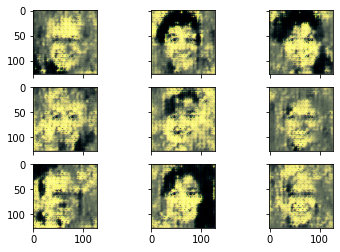

1/1 [==============================] - 0s 90ms/step
Iteration 1100 [D loss: 0.333794, acc.:87.50%] [G loss: 2.404567]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

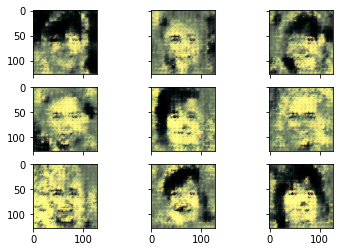

1/1 [==============================] - 0s 92ms/step
Iteration 1150 [D loss: 0.252590, acc.:95.31%] [G loss: 2.198844]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

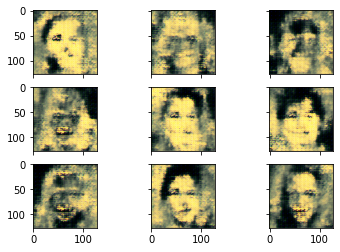

1/1 [==============================] - 0s 108ms/step
Iteration 1200 [D loss: 0.569629, acc.:67.19%] [G loss: 1.836444]
1/1 [==============================] - 0s 54ms/step


<Figure size 216x216 with 0 Axes>

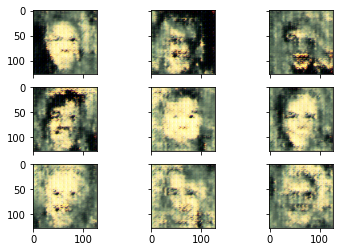

1/1 [==============================] - 0s 90ms/step
Iteration 1250 [D loss: 0.273218, acc.:92.19%] [G loss: 2.154319]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

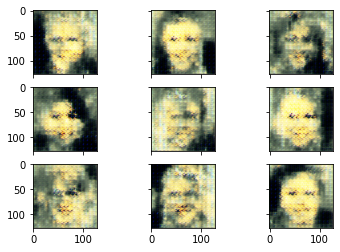

1/1 [==============================] - 0s 91ms/step
Iteration 1300 [D loss: 0.482290, acc.:76.56%] [G loss: 2.001791]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

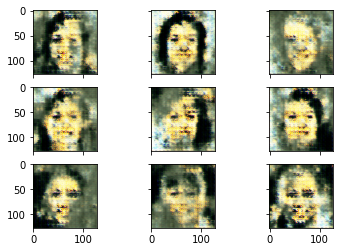

1/1 [==============================] - 0s 94ms/step
Iteration 1350 [D loss: 0.414705, acc.:82.81%] [G loss: 2.068813]
1/1 [==============================] - 0s 45ms/step


<Figure size 216x216 with 0 Axes>

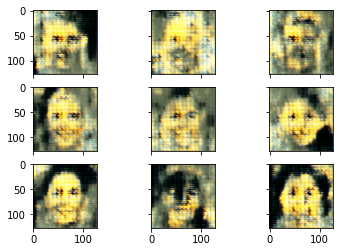

1/1 [==============================] - 0s 92ms/step
Iteration 1400 [D loss: 0.525693, acc.:71.88%] [G loss: 2.272666]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

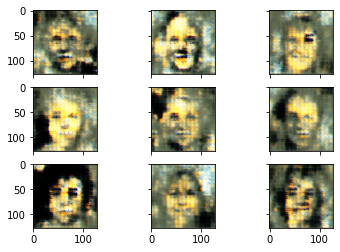

1/1 [==============================] - 0s 94ms/step
Iteration 1450 [D loss: 0.458154, acc.:81.25%] [G loss: 1.647996]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

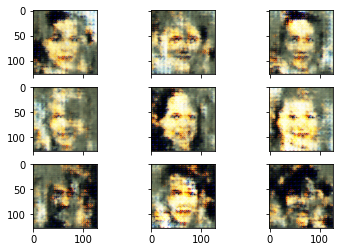

1/1 [==============================] - 0s 90ms/step
Iteration 1500 [D loss: 0.579138, acc.:67.19%] [G loss: 1.951467]
1/1 [==============================] - 0s 45ms/step


<Figure size 216x216 with 0 Axes>

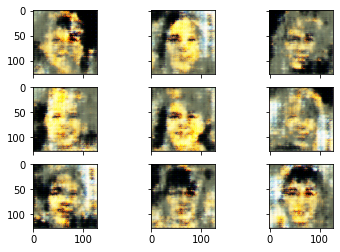

1/1 [==============================] - 0s 90ms/step
Iteration 1550 [D loss: 0.716120, acc.:57.81%] [G loss: 1.832898]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

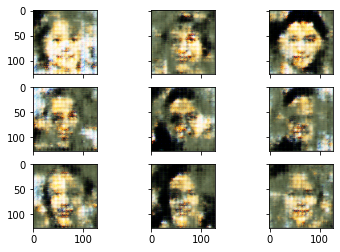

1/1 [==============================] - 0s 92ms/step
Iteration 1600 [D loss: 0.400139, acc.:85.94%] [G loss: 2.472723]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

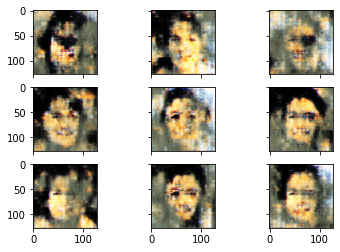

1/1 [==============================] - 0s 98ms/step
Iteration 1650 [D loss: 0.532555, acc.:73.44%] [G loss: 2.043652]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

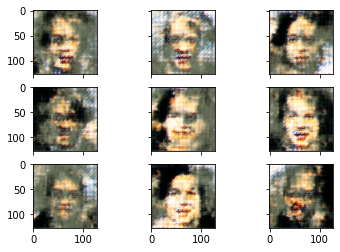

1/1 [==============================] - 0s 93ms/step
Iteration 1700 [D loss: 0.460987, acc.:81.25%] [G loss: 2.434080]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

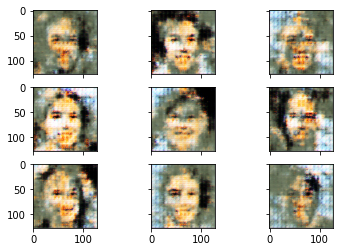

1/1 [==============================] - 0s 94ms/step
Iteration 1750 [D loss: 0.474178, acc.:76.56%] [G loss: 2.173413]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

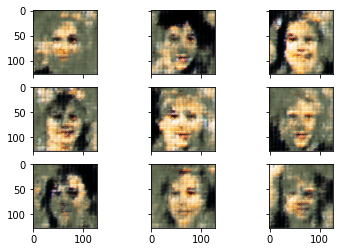

1/1 [==============================] - 0s 100ms/step
Iteration 1800 [D loss: 0.280657, acc.:95.31%] [G loss: 2.677688]
1/1 [==============================] - 0s 45ms/step


<Figure size 216x216 with 0 Axes>

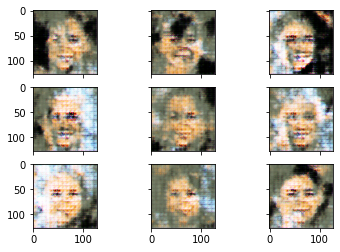

1/1 [==============================] - 0s 105ms/step
Iteration 1850 [D loss: 0.302961, acc.:87.50%] [G loss: 2.731802]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

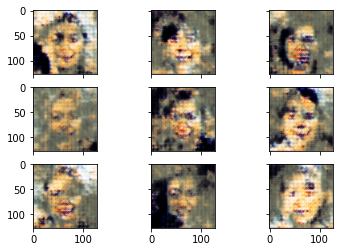

1/1 [==============================] - 0s 100ms/step
Iteration 1900 [D loss: 0.455529, acc.:79.69%] [G loss: 1.981157]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

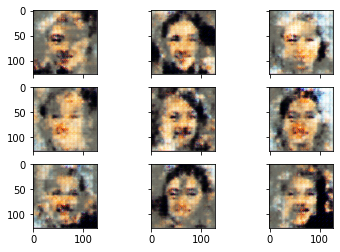

1/1 [==============================] - 0s 101ms/step
Iteration 1950 [D loss: 0.504436, acc.:78.12%] [G loss: 2.705256]
1/1 [==============================] - 0s 50ms/step


<Figure size 216x216 with 0 Axes>

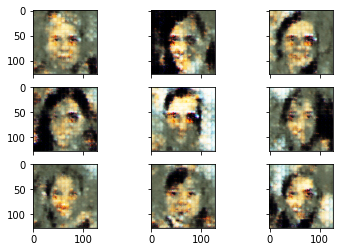

1/1 [==============================] - 0s 97ms/step
Iteration 2000 [D loss: 0.173687, acc.:96.88%] [G loss: 2.614330]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

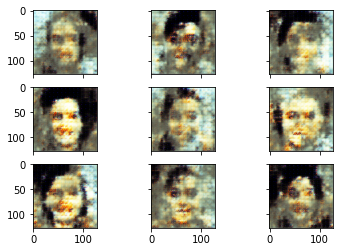

INFO:tensorflow:Assets written to: ./model-02/generator/assets


INFO:tensorflow:Assets written to: ./model-02/generator/assets


INFO:tensorflow:Assets written to: ./model-02/discriminator/assets


INFO:tensorflow:Assets written to: ./model-02/discriminator/assets


INFO:tensorflow:Assets written to: ./model-02/gan/assets


INFO:tensorflow:Assets written to: ./model-02/gan/assets


In [40]:
train_gan(iterations, batch_size, sample_interval, folder_name)

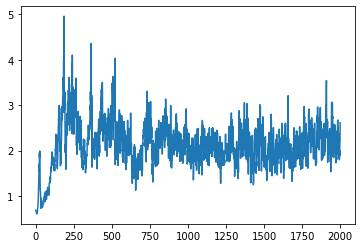

In [41]:
plt.plot(gan_losses)
plt.show()

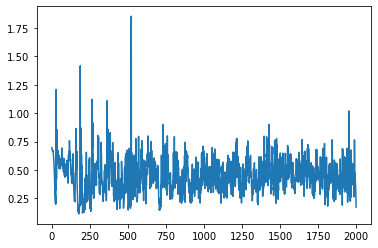

In [42]:
plt.plot(discriminator_losses)

In [112]:
fake_image_01 = tf.random.normal([1, 128], mean=0, stddev=1)

In [113]:
fake_gen_image_01 = generator.predict(fake_image_01)

1/1 [==============================] - 0s 29ms/step


In [114]:
fake_gen_image_01 = 0.5 * fake_gen_image_01 + 0.5

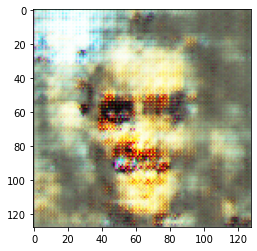

In [115]:
plt.imshow(fake_gen_image_01[0, :, :, :])

(array([  666.,   778.,  1935.,  8367., 11072.,  6938.,  5136.,  4074.,
         3626.,  6560.]),
 array([2.17854977e-05, 1.00019425e-01, 2.00017065e-01, 3.00014704e-01,
        4.00012344e-01, 5.00009954e-01, 6.00007594e-01, 7.00005233e-01,
        8.00002873e-01, 9.00000513e-01, 9.99998152e-01]),
 <BarContainer object of 10 artists>)

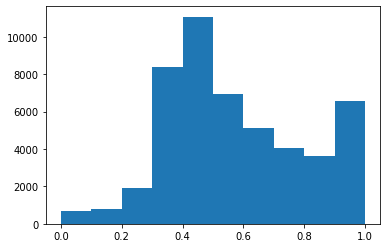

In [116]:
plt.hist(fake_gen_image_01.flatten())

(array([  747.,  2519.,  2442.,  2832.,  3720.,  4671.,  3871.,  3552.,
        23713.,  1085.]),
 array([  3. ,  27.7,  52.4,  77.1, 101.8, 126.5, 151.2, 175.9, 200.6,
        225.3, 250. ]),
 <BarContainer object of 10 artists>)

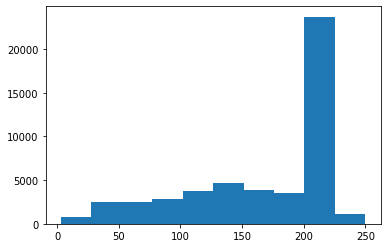

In [117]:
plt.hist(collection[5].flatten())